# 🚀 Transformer EN→RU для Kaggle GPU

**Оптимизированная версия для обучения в Kaggle с GPU**

## ✨ Особенности для Kaggle:
- 🔥 **GPU оптимизация** - эффективное использование P100/T4 
- 💾 **Автосохранение** - checkpoint'ы в `/kaggle/working/`
- 🤗 **Готовые токенизаторы** - BERT/mBERT без дополнительных загрузок
- 📊 **Мониторинг** - визуализация прогресса обучения
- ⚡ **Быстрый старт** - готово к запуску одной кнопкой

## 🎯 Что будет обучено:
- **Модель**: Transformer Encoder-Decoder
- **Датасет**: Tatoeba EN-RU (~400k пар)
- **Метрики**: BLEU, Loss, Perplexity
- **Результат**: Рабочая модель машинного перевода


In [4]:
# 📦 Установка зависимостей и импорты для Kaggle
import sys
import subprocess

# Устанавливаем необходимые пакеты
def install_packages():
    packages = ['transformers', 'datasets', 'nltk', 'wandb']
    for package in packages:
        try:
            __import__(package)
            print(f"✅ {package} уже установлен")
        except ImportError:
            print(f"📦 Устанавливаем {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

install_packages()

# Основные импорты
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
import re
import os
import json
import pickle
from collections import Counter, defaultdict
import pandas as pd
from typing import List, Tuple, Dict, Optional, Union
from datetime import datetime
import time
import gc

warnings.filterwarnings('ignore')

# Kaggle-специфичные настройки
plt.style.use('default')  # Kaggle совместимый стиль
sns.set_palette("husl")

# Проверка и настройка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Устройство: {device}")

if torch.cuda.is_available():
    print(f"🔥 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"🔧 CUDA версия: {torch.version.cuda}")
    # Оптимизация для GPU
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
else:
    print("⚠️ GPU недоступно, используем CPU")

# Kaggle paths
KAGGLE_WORKING = '/kaggle/working'
KAGGLE_INPUT = '/kaggle/input'

# Создаём директории для сохранения
os.makedirs(f'{KAGGLE_WORKING}/checkpoints', exist_ok=True)
os.makedirs(f'{KAGGLE_WORKING}/models', exist_ok=True)
os.makedirs(f'{KAGGLE_WORKING}/outputs', exist_ok=True)

# Seed для воспроизводимости
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
set_seed(42)

print("🚀 Инициализация для Kaggle завершена!")


✅ transformers уже установлен
✅ datasets уже установлен
✅ nltk уже установлен
✅ wandb уже установлен
🖥️ Устройство: cuda
🔥 GPU: Tesla T4
💾 Память GPU: 15.8 GB
🔧 CUDA версия: 12.4
🚀 Инициализация для Kaggle завершена!


In [5]:
# 🤗 Токенизаторы и утилиты для Kaggle
from transformers import AutoTokenizer, AutoModel

class KaggleTokenizer:
    """Токенизатор оптимизированный для Kaggle"""
    
    def __init__(self, model_name: str, language: str = 'en', cache_dir: str = None):
        self.model_name = model_name
        self.language = language
        self.cache_dir = cache_dir or f'{KAGGLE_WORKING}/tokenizer_cache'
        
        # Специальные токены
        self.special_tokens = ['<PAD>', '<BOS>', '<EOS>', '<UNK>']
        
        print(f"🤗 Загружаем токенизатор: {model_name}")
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(
                model_name, 
                cache_dir=self.cache_dir,
                local_files_only=False
            )
            
            # Добавляем специальные токены если нужно
            special_tokens_dict = {}
            if self.tokenizer.pad_token is None:
                special_tokens_dict['pad_token'] = '<PAD>'
            if self.tokenizer.bos_token is None:
                special_tokens_dict['bos_token'] = '<BOS>'
            if self.tokenizer.eos_token is None:
                special_tokens_dict['eos_token'] = '<EOS>'
            if self.tokenizer.unk_token is None:
                special_tokens_dict['unk_token'] = '<UNK>'
                
            if special_tokens_dict:
                num_added = self.tokenizer.add_special_tokens(special_tokens_dict)
                print(f"   Добавлено {num_added} специальных токенов")
                
            self.vocab_size = len(self.tokenizer)
            print(f"✅ Токенизатор загружен: {self.vocab_size:,} токенов")
            
        except Exception as e:
            print(f"❌ Ошибка загрузки токенизатора: {e}")
            raise
    
    def encode(self, text: str, max_length: int = 128, add_special_tokens: bool = True) -> List[int]:
        """Кодирование с ограничением длины для GPU эффективности"""
        encoding = self.tokenizer(
            text,
            max_length=max_length,
            padding=False,
            truncation=True,
            add_special_tokens=add_special_tokens,
            return_tensors=None
        )
        return encoding['input_ids']
    
    def encode_batch(self, texts: List[str], max_length: int = 128, 
                    add_special_tokens: bool = True) -> Dict[str, torch.Tensor]:
        """Batch кодирование для эффективности"""
        encoding = self.tokenizer(
            texts,
            max_length=max_length,
            padding=True,
            truncation=True,
            add_special_tokens=add_special_tokens,
            return_tensors='pt'
        )
        return encoding
    
    def decode(self, ids: List[int], skip_special_tokens: bool = True) -> str:
        """Декодирование"""
        return self.tokenizer.decode(ids, skip_special_tokens=skip_special_tokens)
    
    def decode_batch(self, ids_batch: torch.Tensor, skip_special_tokens: bool = True) -> List[str]:
        """Batch декодирование"""
        return self.tokenizer.batch_decode(ids_batch, skip_special_tokens=skip_special_tokens)
    
    def get_special_token_ids(self) -> Dict[str, int]:
        """Получение ID специальных токенов"""
        return {
            'pad': self.tokenizer.pad_token_id,
            'bos': self.tokenizer.bos_token_id or self.tokenizer.cls_token_id,
            'eos': self.tokenizer.eos_token_id or self.tokenizer.sep_token_id,
            'unk': self.tokenizer.unk_token_id
        }
    
    def save(self, path: str):
        """Сохранение токенизатора"""
        save_path = f"{KAGGLE_WORKING}/{path}"
        os.makedirs(save_path, exist_ok=True)
        self.tokenizer.save_pretrained(save_path)
        print(f"💾 Токенизатор сохранён: {save_path}")

# Создаём токенизаторы для Kaggle
print("🚀 Настройка токенизаторов для Kaggle...")

# Оптимальные модели для EN-RU перевода в Kaggle
try:
    en_tokenizer = KaggleTokenizer('bert-base-uncased', 'en')
    ru_tokenizer = KaggleTokenizer('bert-base-multilingual-cased', 'ru')
except Exception as e:
    print(f"⚠️ Ошибка загрузки BERT токенизаторов: {e}")
    print("🔄 Пробуем альтернативные токенизаторы...")
    try:
        en_tokenizer = KaggleTokenizer('distilbert-base-uncased', 'en')
        ru_tokenizer = KaggleTokenizer('distilbert-base-multilingual-cased', 'ru')
    except:
        print("❌ Не удалось загрузить токенизаторы")
        raise

print(f"📚 Токенизаторы готовы:")
print(f"   🇺🇸 EN: {en_tokenizer.vocab_size:,} токенов")
print(f"   🇷🇺 RU: {ru_tokenizer.vocab_size:,} токенов")

# Тестирование токенизаторов
test_en = "Hello, how are you today?"
test_ru = "Привет, как дела сегодня?"

en_ids = en_tokenizer.encode(test_en, max_length=32)
ru_ids = ru_tokenizer.encode(test_ru, max_length=32)

print(f"\n🧪 Тест токенизации:")
print(f"EN: '{test_en}' -> {len(en_ids)} токенов")
print(f"RU: '{test_ru}' -> {len(ru_ids)} токенов")
print(f"Декодирование EN: '{en_tokenizer.decode(en_ids)}'")
print(f"Декодирование RU: '{ru_tokenizer.decode(ru_ids)}'")

print("✅ Токенизаторы протестированы и готовы!")


🚀 Настройка токенизаторов для Kaggle...
🤗 Загружаем токенизатор: bert-base-uncased
   Добавлено 2 специальных токенов
✅ Токенизатор загружен: 30,524 токенов
🤗 Загружаем токенизатор: bert-base-multilingual-cased
   Добавлено 2 специальных токенов
✅ Токенизатор загружен: 119,549 токенов
📚 Токенизаторы готовы:
   🇺🇸 EN: 30,524 токенов
   🇷🇺 RU: 119,549 токенов

🧪 Тест токенизации:
EN: 'Hello, how are you today?' -> 9 токенов
RU: 'Привет, как дела сегодня?' -> 9 токенов
Декодирование EN: 'hello, how are you today?'
Декодирование RU: 'Привет, как дела сегодня?'
✅ Токенизаторы протестированы и готовы!


In [6]:
# 📂 Загрузка и обработка датасета для Kaggle

def load_kaggle_dataset(max_samples: int = 200000) -> List[Tuple[str, str]]:
    """
    Загрузка датасета в Kaggle environment
    Автоматически ищет файл rus.txt в разных локациях
    """
    possible_paths = [
        '/kaggle/input/rus.txt',
        '/kaggle/input/*/rus.txt',
        './rus.txt',
        '../input/rus.txt'
    ]
    
    dataset_path = None
    for path_pattern in possible_paths:
        import glob
        matches = glob.glob(path_pattern)
        if matches:
            dataset_path = matches[0]
            break
    
    if not dataset_path:
        print("⚠️ Файл rus.txt не найден, создаём демо-датасет")
        return create_demo_dataset()
    
    print(f"📂 Найден датасет: {dataset_path}")
    pairs = []
    
    try:
        with open(dataset_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(tqdm(f, desc="Загрузка датасета")):
                if max_samples and i >= max_samples:
                    break
                    
                line = line.strip()
                if not line:
                    continue
                
                parts = line.split('\t')
                if len(parts) >= 2:
                    english = parts[0].strip()
                    russian = parts[1].strip()
                    
                    # Фильтрация по длине для GPU эффективности
                    en_words = len(english.split())
                    ru_words = len(russian.split())
                    
                    if 1 <= en_words <= 30 and 1 <= ru_words <= 30:  # Короче для Kaggle
                        pairs.append((english, russian))
                
                if (i + 1) % 50000 == 0:
                    print(f"   Обработано {i + 1:,}, найдено {len(pairs):,} пар")
    
    except Exception as e:
        print(f"❌ Ошибка загрузки: {e}")
        return create_demo_dataset()
    
    print(f"✅ Загружено {len(pairs):,} пар переводов")
    return pairs

def create_demo_dataset() -> List[Tuple[str, str]]:
    """Создание демо-датасета если основной недоступен"""
    demo_pairs = [
        ("Hello world", "Привет мир"),
        ("How are you?", "Как дела?"),
        ("Good morning", "Доброе утро"), 
        ("Good evening", "Добрый вечер"),
        ("Thank you", "Спасибо"),
        ("You are welcome", "Пожалуйста"),
        ("I love you", "Я люблю тебя"),
        ("What is your name?", "Как тебя зовут?"),
        ("My name is John", "Меня зовут Джон"),
        ("Where are you from?", "Откуда ты?"),
        ("I am from Russia", "Я из России"),
        ("This is beautiful", "Это красиво"),
        ("I want to learn", "Я хочу учиться"),
        ("Can you help me?", "Можешь помочь мне?"),
        ("Of course I can", "Конечно могу"),
        ("What time is it?", "Который час?"),
        ("I am hungry", "Я голоден"),
        ("The weather is nice", "Погода хорошая"),
        ("I need to go", "Мне нужно идти"),
        ("See you tomorrow", "Увидимся завтра")
    ]
    # Дублируем для увеличения размера
    return demo_pairs * 100  # 2000 пар для демо

def smart_split_dataset(pairs: List[Tuple[str, str]], train_ratio=0.8, val_ratio=0.1):
    """Умное разделение датасета с перемешиванием"""
    # Перемешиваем
    np.random.shuffle(pairs)
    
    total = len(pairs)
    train_size = int(total * train_ratio)
    val_size = int(total * val_ratio)
    
    train_pairs = pairs[:train_size]
    val_pairs = pairs[train_size:train_size + val_size]
    test_pairs = pairs[train_size + val_size:]
    
    print(f"📊 Разделение датасета:")
    print(f"   🏋️ Train: {len(train_pairs):,} ({len(train_pairs)/total*100:.1f}%)")
    print(f"   📊 Val:   {len(val_pairs):,} ({len(val_pairs)/total*100:.1f}%)")
    print(f"   🧪 Test:  {len(test_pairs):,} ({len(test_pairs)/total*100:.1f}%)")
    
    return train_pairs, val_pairs, test_pairs

# Загружаем и обрабатываем датасет для Kaggle
print("🚀 Загрузка датасета для Kaggle...")
all_pairs = load_kaggle_dataset(max_samples=200000)  # Ограничиваем для Kaggle

# Разделяем датасет
train_pairs, val_pairs, test_pairs = smart_split_dataset(all_pairs)

# Показываем примеры
print(f"\n📝 Примеры из обучающего датасета:")
for i, (en, ru) in enumerate(train_pairs[:5]):
    print(f"{i+1}. EN: '{en}'")
    print(f"   RU: '{ru}'")
    
print(f"\n📈 Статистики длин предложений:")
en_lengths = [len(pair[0].split()) for pair in train_pairs[:1000]]
ru_lengths = [len(pair[1].split()) for pair in train_pairs[:1000]]

print(f"EN - мин: {min(en_lengths)}, макс: {max(en_lengths)}, среднее: {np.mean(en_lengths):.1f}")
print(f"RU - мин: {min(ru_lengths)}, макс: {max(ru_lengths)}, среднее: {np.mean(ru_lengths):.1f}")

print("✅ Датасет готов для обучения в Kaggle!")


🚀 Загрузка датасета для Kaggle...
📂 Найден датасет: /kaggle/input/en2rus/rus.txt


Загрузка датасета: 0it [00:00, ?it/s]

   Обработано 50,000, найдено 50,000 пар
   Обработано 100,000, найдено 100,000 пар
   Обработано 150,000, найдено 150,000 пар
   Обработано 200,000, найдено 200,000 пар
✅ Загружено 200,000 пар переводов
📊 Разделение датасета:
   🏋️ Train: 160,000 (80.0%)
   📊 Val:   20,000 (10.0%)
   🧪 Test:  20,000 (10.0%)

📝 Примеры из обучающего датасета:
1. EN: 'You'd better read this.'
   RU: 'Вам лучше прочесть это.'
2. EN: 'Tom says he'll swim.'
   RU: 'Том говорит, что искупается.'
3. EN: 'I'd never do that for Tom.'
   RU: 'Я бы никогда не сделал этого для Тома.'
4. EN: 'I need it right now.'
   RU: 'Оно мне нужно прямо сейчас.'
5. EN: 'I planted a tree.'
   RU: 'Я посадил дерево.'

📈 Статистики длин предложений:
EN - мин: 1, макс: 8, среднее: 4.6
RU - мин: 1, макс: 9, среднее: 4.2
✅ Датасет готов для обучения в Kaggle!


## 🏗️ Архитектура Transformer для Kaggle

Компактная но эффективная реализация, оптимизированная для GPU в Kaggle


In [7]:
# 🏗️ Базовые компоненты Transformer

class PositionalEncoding(nn.Module):
    """Синусоидальное позиционное кодирование"""
    
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    """Multi-Head Attention для Kaggle GPU"""
    
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)
        
        # Инициализация весов
        for module in [self.w_q, self.w_k, self.w_v, self.w_o]:
            nn.init.xavier_uniform_(module.weight)
    
    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, 
                mask: torch.Tensor = None, causal_mask: bool = False) -> torch.Tensor:
        batch_size, seq_len_q = query.shape[:2]
        seq_len_k = key.shape[1]
        
        # Проекции Q, K, V
        Q = self.w_q(query).view(batch_size, seq_len_q, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, seq_len_k, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, seq_len_k, self.n_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        # Causal mask для decoder
        if causal_mask:
            causal_mask_tensor = torch.tril(torch.ones(seq_len_q, seq_len_q, device=query.device))
            scores = scores.masked_fill(causal_mask_tensor == 0, float('-inf'))
        
        # Padding mask
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        output = torch.matmul(attention_weights, V)
        
        # Concatenate heads
        output = output.transpose(1, 2).contiguous().view(
            batch_size, seq_len_q, self.d_model
        )
        output = self.w_o(output)
        
        return output

class FeedForward(nn.Module):
    """Position-wise Feed-Forward Network"""
    
    def __init__(self, d_model: int, d_ff: int = None, dropout: float = 0.1):
        super().__init__()
        if d_ff is None:
            d_ff = 4 * d_model
        
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.gelu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

print("✅ Базовые компоненты Transformer готовы")


✅ Базовые компоненты Transformer готовы


In [8]:
# 🔗 Encoder-Decoder слои

class TransformerEncoderLayer(nn.Module):
    """Слой Encoder с self-attention"""
    
    def __init__(self, d_model: int, n_heads: int, d_ff: int = None, dropout: float = 0.1):
        super().__init__()
        
        self.self_attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor, src_mask: torch.Tensor = None) -> torch.Tensor:
        # Self-attention + residual
        norm_x = self.ln1(x)
        attention_output = self.self_attention(norm_x, norm_x, norm_x, mask=src_mask)
        x = x + self.dropout(attention_output)
        
        # Feed-forward + residual
        norm_x = self.ln2(x)
        ff_output = self.feed_forward(norm_x)
        x = x + self.dropout(ff_output)
        
        return x

class TransformerDecoderLayer(nn.Module):
    """Слой Decoder с masked self-attention и cross-attention"""
    
    def __init__(self, d_model: int, n_heads: int, d_ff: int = None, dropout: float = 0.1):
        super().__init__()
        
        # Masked self-attention
        self.self_attention = MultiHeadAttention(d_model, n_heads, dropout)
        # Cross-attention с encoder
        self.cross_attention = MultiHeadAttention(d_model, n_heads, dropout)
        # Feed-forward
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ln3 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor, memory: torch.Tensor, 
                tgt_mask: torch.Tensor = None, src_mask: torch.Tensor = None) -> torch.Tensor:
        # 1. Masked self-attention
        norm_x = self.ln1(x)
        self_attn_output = self.self_attention(
            norm_x, norm_x, norm_x, 
            mask=tgt_mask, causal_mask=True
        )
        x = x + self.dropout(self_attn_output)
        
        # 2. Cross-attention с encoder memory
        norm_x = self.ln2(x)
        cross_attn_output = self.cross_attention(
            norm_x, memory, memory,
            mask=src_mask
        )
        x = x + self.dropout(cross_attn_output)
        
        # 3. Feed-forward
        norm_x = self.ln3(x)
        ff_output = self.feed_forward(norm_x)
        x = x + self.dropout(ff_output)
        
        return x

class TransformerEncoder(nn.Module):
    """Стек encoder слоёв"""
    
    def __init__(self, n_layers: int, d_model: int, n_heads: int, d_ff: int = None, dropout: float = 0.1):
        super().__init__()
        
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        self.ln_final = nn.LayerNorm(d_model)
    
    def forward(self, x: torch.Tensor, src_mask: torch.Tensor = None) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x, src_mask)
        
        return self.ln_final(x)

class TransformerDecoder(nn.Module):
    """Стек decoder слоёв"""
    
    def __init__(self, n_layers: int, d_model: int, n_heads: int, d_ff: int = None, dropout: float = 0.1):
        super().__init__()
        
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        self.ln_final = nn.LayerNorm(d_model)
    
    def forward(self, x: torch.Tensor, memory: torch.Tensor,
                tgt_mask: torch.Tensor = None, src_mask: torch.Tensor = None) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x, memory, tgt_mask, src_mask)
        
        return self.ln_final(x)

print("✅ Encoder-Decoder слои готовы")


✅ Encoder-Decoder слои готовы


In [9]:
# 🤖 Полная модель Transformer для перевода

class KaggleTransformer(nn.Module):
    """
    Полная модель Transformer для машинного перевода EN→RU
    Оптимизированная для обучения в Kaggle
    """
    
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int, d_model: int = 256, 
                 n_heads: int = 8, n_layers: int = 4, d_ff: int = None, 
                 max_seq_len: int = 128, dropout: float = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        
        # Embeddings
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        
        # Позиционное кодирование
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len, dropout)
        
        # Encoder и Decoder
        self.encoder = TransformerEncoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = TransformerDecoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        # Выходная проекция
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
        
        # Инициализация весов
        self._init_weights()
        
        # Сохраняем конфигурацию
        self.config = {
            'src_vocab_size': src_vocab_size,
            'tgt_vocab_size': tgt_vocab_size,
            'd_model': d_model,
            'n_heads': n_heads,
            'n_layers': n_layers,
            'max_seq_len': max_seq_len
        }
    
    def _init_weights(self):
        """Инициализация весов модели"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def create_padding_mask(self, x: torch.Tensor, pad_token_id: int = 0) -> torch.Tensor:
        """Создает маску для padding токенов"""
        return (x != pad_token_id).unsqueeze(1).unsqueeze(2)
    
    def forward(self, src_ids: torch.Tensor, tgt_ids: torch.Tensor = None, 
                src_pad_token: int = 0, tgt_pad_token: int = 0) -> torch.Tensor:
        """
        Forward pass модели
        
        Args:
            src_ids: Source token IDs (batch_size, src_seq_len)
            tgt_ids: Target token IDs (batch_size, tgt_seq_len) - для обучения
            src_pad_token: ID токена padding для source
            tgt_pad_token: ID токена padding для target
        """
        # Создаем маски
        src_mask = self.create_padding_mask(src_ids, src_pad_token)
        
        # Source embeddings + positional encoding
        src_emb = self.src_embedding(src_ids) * math.sqrt(self.d_model)
        src_emb = self.pos_encoding(src_emb)
        
        # Encode source sequence
        memory = self.encoder(src_emb, src_mask)
        
        if tgt_ids is not None:
            # Training mode - используем teacher forcing
            tgt_mask = self.create_padding_mask(tgt_ids, tgt_pad_token)
            
            # Target embeddings + positional encoding
            tgt_emb = self.tgt_embedding(tgt_ids) * math.sqrt(self.d_model)
            tgt_emb = self.pos_encoding(tgt_emb)
            
            # Decode
            decoder_output = self.decoder(tgt_emb, memory, tgt_mask, src_mask)
            
            # Project to target vocabulary
            logits = self.output_projection(decoder_output)
            
            return logits
        else:
            # Inference mode - возвращаем encoder memory
            return memory
    
    def generate_translation(self, src_ids: torch.Tensor, max_length: int = 50,
                           bos_token: int = 1, eos_token: int = 2, pad_token: int = 0) -> torch.Tensor:
        """
        Генерация перевода с greedy decoding
        Оптимизировано для Kaggle GPU
        """
        self.eval()
        batch_size = src_ids.size(0)
        device = src_ids.device
        
        # Encode source
        src_mask = self.create_padding_mask(src_ids, pad_token)
        src_emb = self.src_embedding(src_ids) * math.sqrt(self.d_model)
        src_emb = self.pos_encoding(src_emb)
        memory = self.encoder(src_emb, src_mask)
        
        # Greedy decoding
        tgt_ids = torch.full((batch_size, 1), bos_token, dtype=torch.long, device=device)
        
        for _ in range(max_length - 1):
            tgt_mask = self.create_padding_mask(tgt_ids, pad_token)
            
            # Target embeddings
            tgt_emb = self.tgt_embedding(tgt_ids) * math.sqrt(self.d_model)
            tgt_emb = self.pos_encoding(tgt_emb)
            
            # Decode
            decoder_output = self.decoder(tgt_emb, memory, tgt_mask, src_mask)
            
            # Получаем логиты для последнего токена
            logits = self.output_projection(decoder_output[:, -1, :])
            
            # Выбираем следующий токен
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
            
            # Добавляем к последовательности
            tgt_ids = torch.cat([tgt_ids, next_token], dim=1)
            
            # Проверяем на EOS токен
            if next_token.item() == eos_token:
                break
        
        return tgt_ids
    
    def count_parameters(self) -> int:
        """Подсчет количества параметров"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def get_config(self) -> Dict:
        """Получение конфигурации модели"""
        return self.config

# Тестируем архитектуру
print("🚀 Создаём модель Transformer...")

# Параметры оптимизированные для Kaggle
MODEL_CONFIG = {
    'src_vocab_size': en_tokenizer.vocab_size,
    'tgt_vocab_size': ru_tokenizer.vocab_size,
    'd_model': 256,       # Оптимально для P100/T4
    'n_heads': 8,
    'n_layers': 4,        # Баланс качества и скорости
    'd_ff': 1024,         # 4 * d_model
    'max_seq_len': 128,
    'dropout': 0.1
}

model = KaggleTransformer(**MODEL_CONFIG).to(device)

print(f"✅ Модель создана:")
print(f"   📊 Параметров: {model.count_parameters():,}")
print(f"   🔧 Размер модели: {model.count_parameters() * 4 / 1e6:.1f} MB")
print(f"   🖥️ Устройство: {next(model.parameters()).device}")

# Быстрый тест forward pass
print(f"\n🧪 Тестирование архитектуры...")
test_src = torch.randint(1, en_tokenizer.vocab_size, (2, 10)).to(device)
test_tgt = torch.randint(1, ru_tokenizer.vocab_size, (2, 8)).to(device)

with torch.no_grad():
    # Test training mode
    logits = model(test_src, test_tgt)
    print(f"   Training mode: {logits.shape}")
    
    # Test inference mode  
    translation = model.generate_translation(test_src[:1], max_length=15)
    print(f"   Generation: {translation.shape}")

print(f"✅ Архитектура Transformer готова к обучению!")


🚀 Создаём модель Transformer...
✅ Модель создана:
   📊 Параметров: 76,507,389
   🔧 Размер модели: 306.0 MB
   🖥️ Устройство: cuda:0

🧪 Тестирование архитектуры...
   Training mode: torch.Size([2, 8, 119549])
   Generation: torch.Size([1, 15])
✅ Архитектура Transformer готова к обучению!


In [10]:
# 📚 Dataset и DataLoader для Kaggle

class KaggleTranslationDataset(Dataset):
    """Dataset для машинного перевода оптимизированный для Kaggle"""
    
    def __init__(self, pairs: List[Tuple[str, str]], src_tokenizer: KaggleTokenizer, 
                 tgt_tokenizer: KaggleTokenizer, max_length: int = 64):
        self.pairs = pairs
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_length = max_length
        
        # Получаем специальные токены
        self.src_special = src_tokenizer.get_special_token_ids()
        self.tgt_special = tgt_tokenizer.get_special_token_ids()
        
        print(f"📚 Dataset создан: {len(pairs)} пар, max_length={max_length}")
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        src_text, tgt_text = self.pairs[idx]
        
        # Кодируем тексты
        src_ids = self.src_tokenizer.encode(src_text, max_length=self.max_length)
        tgt_ids = self.tgt_tokenizer.encode(tgt_text, max_length=self.max_length)
        
        # Входная последовательность для decoder (все токены кроме последнего)
        decoder_input = tgt_ids[:-1]
        # Целевая последовательность (все токены кроме первого BOS)
        decoder_target = tgt_ids[1:]
        
        return {
            'src_ids': torch.tensor(src_ids, dtype=torch.long),
            'decoder_input': torch.tensor(decoder_input, dtype=torch.long),
            'decoder_target': torch.tensor(decoder_target, dtype=torch.long),
            'src_text': src_text,
            'tgt_text': tgt_text
        }

def kaggle_collate_fn(batch):
    """Эффективная функция для padding в batch"""
    src_ids = [item['src_ids'] for item in batch]
    decoder_inputs = [item['decoder_input'] for item in batch]
    decoder_targets = [item['decoder_target'] for item in batch]
    
    # Padding до максимальной длины в batch
    src_ids = nn.utils.rnn.pad_sequence(src_ids, batch_first=True, padding_value=0)
    decoder_inputs = nn.utils.rnn.pad_sequence(decoder_inputs, batch_first=True, padding_value=0)
    decoder_targets = nn.utils.rnn.pad_sequence(decoder_targets, batch_first=True, padding_value=0)
    
    return {
        'src_ids': src_ids,
        'decoder_input': decoder_inputs,
        'decoder_target': decoder_targets,
        'src_texts': [item['src_text'] for item in batch],
        'tgt_texts': [item['tgt_text'] for item in batch]
    }

# Создаём datasets и dataloaders
print("📚 Создаём DataLoader'ы для Kaggle...")

# Параметры для Kaggle
MAX_LENGTH = 64
BATCH_SIZE = 64 if torch.cuda.is_available() else 16

# Создаём datasets
train_dataset = KaggleTranslationDataset(train_pairs, en_tokenizer, ru_tokenizer, MAX_LENGTH)
val_dataset = KaggleTranslationDataset(val_pairs, en_tokenizer, ru_tokenizer, MAX_LENGTH)
test_dataset = KaggleTranslationDataset(test_pairs, en_tokenizer, ru_tokenizer, MAX_LENGTH)

# Создаём dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=kaggle_collate_fn,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=kaggle_collate_fn,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=kaggle_collate_fn,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✅ DataLoader'ы готовы:")
print(f"   🏋️ Train: {len(train_loader)} батчей по {BATCH_SIZE}")
print(f"   📊 Val:   {len(val_loader)} батчей по {BATCH_SIZE}")
print(f"   🧪 Test:  {len(test_loader)} батчей по {BATCH_SIZE}")

# Тестируем один batch
print(f"\n🧪 Тестирование DataLoader...")
for batch in train_loader:
    print(f"   Src shape: {batch['src_ids'].shape}")
    print(f"   Decoder input: {batch['decoder_input'].shape}")
    print(f"   Decoder target: {batch['decoder_target'].shape}")
    
    # Показываем пример
    print(f"   Пример:")
    print(f"     EN: '{batch['src_texts'][0]}'")
    print(f"     RU: '{batch['tgt_texts'][0]}'")
    break

print("✅ Dataset и DataLoader протестированы!")


📚 Создаём DataLoader'ы для Kaggle...
📚 Dataset создан: 160000 пар, max_length=64
📚 Dataset создан: 20000 пар, max_length=64
📚 Dataset создан: 20000 пар, max_length=64
✅ DataLoader'ы готовы:
   🏋️ Train: 2500 батчей по 64
   📊 Val:   313 батчей по 64
   🧪 Test:  313 батчей по 64

🧪 Тестирование DataLoader...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   Src shape: torch.Size([64, 11])
   Decoder input: torch.Size([64, 16])
   Decoder target: torch.Size([64, 16])
   Пример:
     EN: 'They don't know French.'
     RU: 'Они не знают французского.'
✅ Dataset и DataLoader протестированы!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [11]:
# 🎯 Функции для обучения и оценки в Kaggle

def calculate_bleu_score(reference: str, candidate: str) -> float:
    """Вычисление BLEU score с fallback"""
    try:
        # Пробуем NLTK
        import nltk
        from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
        
        ref_tokens = reference.lower().split()
        cand_tokens = candidate.lower().split()
        smoothing = SmoothingFunction().method1
        return sentence_bleu([ref_tokens], cand_tokens, smoothing_function=smoothing)
    except:
        # Простая реализация
        ref_words = set(reference.lower().split())
        cand_words = set(candidate.lower().split())
        
        if len(cand_words) == 0:
            return 0.0
        
        matches = len(ref_words & cand_words)
        precision = matches / len(cand_words)
        
        ref_len = len(reference.split())
        cand_len = len(candidate.split())
        
        if cand_len > ref_len:
            bp = 1.0
        else:
            bp = np.exp(1 - ref_len/cand_len) if cand_len > 0 else 0.0
        
        return bp * precision

class KaggleModelManager:
    """Менеджер для сохранения/загрузки моделей в Kaggle"""
    
    @staticmethod
    def save_checkpoint(model, optimizer, scheduler, epoch, loss, bleu, path: str):
        """Сохранение checkpoint в Kaggle"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'loss': loss,
            'bleu': bleu,
            'model_config': model.get_config(),
            'timestamp': datetime.now().isoformat()
        }
        
        full_path = f"{KAGGLE_WORKING}/checkpoints/{path}"
        torch.save(checkpoint, full_path)
        print(f"💾 Checkpoint сохранён: {full_path}")
        return full_path
    
    @staticmethod
    def save_best_model(model, metrics: Dict, path: str):
        """Сохранение лучшей модели"""
        model_data = {
            'model_state_dict': model.state_dict(),
            'model_config': model.get_config(),
            'metrics': metrics,
            'timestamp': datetime.now().isoformat()
        }
        
        full_path = f"{KAGGLE_WORKING}/models/{path}"
        torch.save(model_data, full_path)
        print(f"🏆 Лучшая модель сохранена: {full_path}")
        return full_path

def train_epoch(model, train_loader, optimizer, criterion, device, scheduler=None):
    """Обучение на одной эпохе"""
    model.train()
    total_loss = 0
    total_tokens = 0
    
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for batch_idx, batch in enumerate(progress_bar):
        # Перемещаем данные на GPU
        src_ids = batch['src_ids'].to(device, non_blocking=True)
        decoder_input = batch['decoder_input'].to(device, non_blocking=True)
        decoder_target = batch['decoder_target'].to(device, non_blocking=True)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(src_ids, decoder_input, 
                      src_pad_token=en_tokenizer.get_special_token_ids()['pad'],
                      tgt_pad_token=ru_tokenizer.get_special_token_ids()['pad'])
        
        # Вычисляем loss
        loss = criterion(logits.view(-1, logits.size(-1)), decoder_target.view(-1))
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        # Статистики
        total_loss += loss.item()
        total_tokens += decoder_target.numel()
        
        # Обновляем progress bar
        avg_loss = total_loss / (batch_idx + 1)
        progress_bar.set_postfix({
            'Loss': f'{avg_loss:.4f}',
            'PPL': f'{math.exp(min(avg_loss, 10)):.2f}'
        })
        
        # Очистка памяти GPU каждые 50 батчей
        if batch_idx % 50 == 0:
            torch.cuda.empty_cache()
    
    return total_loss / len(train_loader)

def evaluate_model(model, val_loader, criterion, device, tokenizers, num_examples=5):
    """Оценка модели"""
    model.eval()
    total_loss = 0
    total_bleu = 0
    examples = []
    
    en_tokenizer, ru_tokenizer = tokenizers
    special_tokens = ru_tokenizer.get_special_token_ids()
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation", leave=False)
        
        for batch_idx, batch in enumerate(progress_bar):
            src_ids = batch['src_ids'].to(device, non_blocking=True)
            decoder_input = batch['decoder_input'].to(device, non_blocking=True)
            decoder_target = batch['decoder_target'].to(device, non_blocking=True)
            
            # Forward pass
            logits = model(src_ids, decoder_input,
                          src_pad_token=en_tokenizer.get_special_token_ids()['pad'],
                          tgt_pad_token=ru_tokenizer.get_special_token_ids()['pad'])
            
            # Loss
            loss = criterion(logits.view(-1, logits.size(-1)), decoder_target.view(-1))
            total_loss += loss.item()
            
            # BLEU оценка на первых примерах
            if batch_idx < num_examples and len(examples) < num_examples:
                for i in range(min(3, src_ids.size(0))):
                    if len(examples) >= num_examples:
                        break
                        
                    # Генерируем перевод
                    src_input = src_ids[i:i+1]
                    translation_ids = model.generate_translation(
                        src_input,
                        max_length=50,
                        bos_token=special_tokens['bos'],
                        eos_token=special_tokens['eos'],
                        pad_token=special_tokens['pad']
                    )
                    
                    # Декодируем
                    src_text = batch['src_texts'][i]
                    ref_text = batch['tgt_texts'][i]
                    gen_text = ru_tokenizer.decode(translation_ids[0].tolist())
                    
                    # BLEU
                    bleu = calculate_bleu_score(ref_text, gen_text)
                    total_bleu += bleu
                    
                    examples.append({
                        'source': src_text,
                        'reference': ref_text,
                        'generated': gen_text,
                        'bleu': bleu
                    })
            
            progress_bar.set_postfix({'Loss': f'{total_loss/(batch_idx+1):.4f}'})
    
    avg_loss = total_loss / len(val_loader)
    avg_bleu = total_bleu / len(examples) if examples else 0.0
    
    return avg_loss, avg_bleu, examples

print("✅ Функции обучения и оценки готовы для Kaggle")


✅ Функции обучения и оценки готовы для Kaggle


In [12]:
# 🚀 ОБУЧЕНИЕ TRANSFORMER В KAGGLE

# Параметры обучения для Kaggle
TRAINING_CONFIG = {
    'epochs': 8,                    # Оптимально для 6-часовой сессии
    'learning_rate': 5e-4,          # Эффективный LR для трансформера
    'weight_decay': 0.01,           # L2 регуляризация
    'warmup_steps': 1000,           # Warmup для стабильного обучения
    'save_every': 2,                # Сохранение каждые 2 эпохи
}

print("🔥 Начинаем обучение Transformer в Kaggle!")
print(f"📊 Конфигурация:")
for key, value in TRAINING_CONFIG.items():
    print(f"   {key}: {value}")

# Настройка оптимизатора и scheduler
optimizer = optim.AdamW(
    model.parameters(), 
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay'],
    betas=(0.9, 0.98),
    eps=1e-9
)

# Warmup + Cosine Annealing scheduler
total_steps = len(train_loader) * TRAINING_CONFIG['epochs']
warmup_steps = TRAINING_CONFIG['warmup_steps']

def get_lr_lambda(step):
    if step < warmup_steps:
        return step / warmup_steps
    else:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, get_lr_lambda)

# Loss function
criterion = nn.CrossEntropyLoss(
    ignore_index=ru_tokenizer.get_special_token_ids()['pad'],
    label_smoothing=0.1  # Небольшое сглаживание для лучшей генерализации
)

# Трекинг метрик
train_losses = []
val_losses = []
val_bleus = []
best_bleu = 0.0
best_model_path = None

print(f"\n🎯 Начинаем обучение на {TRAINING_CONFIG['epochs']} эпох...")
print(f"⏰ Время начала: {datetime.now().strftime('%H:%M:%S')}")

start_time = time.time()

for epoch in range(TRAINING_CONFIG['epochs']):
    epoch_start = time.time()
    print(f"\n📅 Эпоха {epoch + 1}/{TRAINING_CONFIG['epochs']}")
    
    # Обучение
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, scheduler)
    train_losses.append(train_loss)
    
    # Валидация
    val_loss, val_bleu, examples = evaluate_model(
        model, val_loader, criterion, device, (en_tokenizer, ru_tokenizer)
    )
    val_losses.append(val_loss)
    val_bleus.append(val_bleu)
    
    # Время эпохи
    epoch_time = time.time() - epoch_start
    
    print(f"📊 Результаты эпохи {epoch + 1}:")
    print(f"   🏋️ Train Loss: {train_loss:.4f} (PPL: {math.exp(min(train_loss, 10)):.2f})")
    print(f"   📊 Val Loss:   {val_loss:.4f} (PPL: {math.exp(min(val_loss, 10)):.2f})")
    print(f"   🎯 Val BLEU:   {val_bleu:.3f}")
    print(f"   ⏱️ Время:      {epoch_time:.1f} сек")
    print(f"   📈 LR:         {scheduler.get_last_lr()[0]:.6f}")
    
    # Показываем примеры переводов
    if examples:
        print(f"\n📝 Примеры переводов:")
        for i, ex in enumerate(examples[:3]):
            print(f"   {i+1}. EN: '{ex['source']}'")
            print(f"      RU: '{ex['reference']}'")
            print(f"      GEN: '{ex['generated']}' (BLEU: {ex['bleu']:.3f})")
    
    # Сохранение checkpoint'а
    if (epoch + 1) % TRAINING_CONFIG['save_every'] == 0:
        checkpoint_path = f"checkpoint_epoch_{epoch + 1}.pth"
        KaggleModelManager.save_checkpoint(
            model, optimizer, scheduler, epoch, train_loss, val_bleu, checkpoint_path
        )
    
    # Сохранение лучшей модели
    if val_bleu > best_bleu:
        best_bleu = val_bleu
        best_model_path = KaggleModelManager.save_best_model(
            model, 
            {'bleu': val_bleu, 'loss': val_loss, 'epoch': epoch + 1},
            "best_model.pth"
        )
        print(f"🏆 Новая лучшая модель! BLEU: {best_bleu:.3f}")
    
    # Очистка памяти
    torch.cuda.empty_cache()
    gc.collect()

total_time = time.time() - start_time
print(f"\n🎉 Обучение завершено!")
print(f"⏰ Общее время: {total_time/3600:.1f} часов")
print(f"🏆 Лучший BLEU: {best_bleu:.3f}")
print(f"💾 Лучшая модель: {best_model_path}")

# Сохранение финального checkpoint'а
final_checkpoint = KaggleModelManager.save_checkpoint(
    model, optimizer, scheduler, TRAINING_CONFIG['epochs']-1, 
    train_losses[-1], val_bleus[-1], "final_checkpoint.pth"
)

print(f"💾 Финальный checkpoint: {final_checkpoint}")


🔥 Начинаем обучение Transformer в Kaggle!
📊 Конфигурация:
   epochs: 8
   learning_rate: 0.0005
   weight_decay: 0.01
   warmup_steps: 1000
   save_every: 2

🎯 Начинаем обучение на 8 эпох...
⏰ Время начала: 09:32:53

📅 Эпоха 1/8


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


📊 Результаты эпохи 1:
   🏋️ Train Loss: 4.7773 (PPL: 118.78)
   📊 Val Loss:   3.0188 (PPL: 20.47)
   🎯 Val BLEU:   0.072
   ⏱️ Время:      330.6 сек
   📈 LR:         0.000492

📝 Примеры переводов:
   1. EN: 'I hate being late.'
      RU: 'Ненавижу опаздывать.'
      GEN: 'мне ненавижу опаздывать....................' (BLEU: 0.114)
   2. EN: 'Tom and I are good friends.'
      RU: 'Том и я — хорошие друзья.'
      GEN: 'с Томом хорошие друзья............. друзей......' (BLEU: 0.044)
   3. EN: 'That's cheap, isn't it?'
      RU: 'Это дёшево, не правда ли?'
      GEN: ', непряёмное,?????????????????????' (BLEU: 0.000)
🏆 Лучшая модель сохранена: /kaggle/working/models/best_model.pth
🏆 Новая лучшая модель! BLEU: 0.072

📅 Эпоха 2/8


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


📊 Результаты эпохи 2:
   🏋️ Train Loss: 2.8075 (PPL: 16.57)
   📊 Val Loss:   2.5623 (PPL: 12.97)
   🎯 Val BLEU:   0.082
   ⏱️ Время:      333.7 сек
   📈 LR:         0.000447

📝 Примеры переводов:
   1. EN: 'I hate being late.'
      RU: 'Ненавижу опаздывать.'
      GEN: 'мне ненавижу опоздать....................' (BLEU: 0.114)
   2. EN: 'Tom and I are good friends.'
      RU: 'Том и я — хорошие друзья.'
      GEN: 'мы с Томом хорошие друзья....................' (BLEU: 0.044)
   3. EN: 'That's cheap, isn't it?'
      RU: 'Это дёшево, не правда ли?'
      GEN: ', это не так ли??????????????????????' (BLEU: 0.064)
💾 Checkpoint сохранён: /kaggle/working/checkpoints/checkpoint_epoch_2.pth
🏆 Лучшая модель сохранена: /kaggle/working/models/best_model.pth
🏆 Новая лучшая модель! BLEU: 0.082

📅 Эпоха 3/8


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


📊 Результаты эпохи 3:
   🏋️ Train Loss: 2.4871 (PPL: 12.03)
   📊 Val Loss:   2.3955 (PPL: 10.97)
   🎯 Val BLEU:   0.079
   ⏱️ Время:      333.1 сек
   📈 LR:         0.000369

📝 Примеры переводов:
   1. EN: 'I hate being late.'
      RU: 'Ненавижу опаздывать.'
      GEN: 'я ненавижу опоздать............... опаздыю...' (BLEU: 0.080)
   2. EN: 'Tom and I are good friends.'
      RU: 'Том и я — хорошие друзья.'
      GEN: 'у нас с Томом хорошие друзья............. друзья. друзья. друз' (BLEU: 0.029)
   3. EN: 'That's cheap, isn't it?'
      RU: 'Это дёшево, не правда ли?'
      GEN: 'ведь это дешёвое?????????????????????' (BLEU: 0.058)

📅 Эпоха 4/8


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


📊 Результаты эпохи 4:
   🏋️ Train Loss: 2.3221 (PPL: 10.20)
   📊 Val Loss:   2.3003 (PPL: 9.98)
   🎯 Val BLEU:   0.078
   ⏱️ Время:      333.2 сек
   📈 LR:         0.000271

📝 Примеры переводов:
   1. EN: 'I hate being late.'
      RU: 'Ненавижу опаздывать.'
      GEN: 'я ненавижу опоздание........... опаздывать.. опаздывать...' (BLEU: 0.054)
   2. EN: 'Tom and I are good friends.'
      RU: 'Том и я — хорошие друзья.'
      GEN: 'мы с Томом хорошие друзья.и..................' (BLEU: 0.044)
   3. EN: 'That's cheap, isn't it?'
      RU: 'Это дёшево, не правда ли?'
      GEN: ', не так ли???????????????????????' (BLEU: 0.063)
💾 Checkpoint сохранён: /kaggle/working/checkpoints/checkpoint_epoch_4.pth

📅 Эпоха 5/8


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


📊 Результаты эпохи 5:
   🏋️ Train Loss: 2.2085 (PPL: 9.10)
   📊 Val Loss:   2.2438 (PPL: 9.43)
   🎯 Val BLEU:   0.075
   ⏱️ Время:      332.9 сек
   📈 LR:         0.000169

📝 Примеры переводов:
   1. EN: 'I hate being late.'
      RU: 'Ненавижу опаздывать.'
      GEN: 'ненавижу опаздывать.......... опоздает... опоздание....' (BLEU: 0.080)
   2. EN: 'Tom and I are good friends.'
      RU: 'Том и я — хорошие друзья.'
      GEN: 'у нас с Томом хорошие друзья.и............... хороших.' (BLEU: 0.033)
   3. EN: 'That's cheap, isn't it?'
      RU: 'Это дёшево, не правда ли?'
      GEN: ', правда?????????????????????? ли?' (BLEU: 0.058)

📅 Эпоха 6/8


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


📊 Результаты эпохи 6:
   🏋️ Train Loss: 2.1254 (PPL: 8.38)
   📊 Val Loss:   2.2058 (PPL: 9.08)
   🎯 Val BLEU:   0.035
   ⏱️ Время:      332.9 сек
   📈 LR:         0.000081

📝 Примеры переводов:
   1. EN: 'I hate being late.'
      RU: 'Ненавижу опаздывать.'
      GEN: 'я ненавижу опаздывать.......... опаздывает...... опаздыва' (BLEU: 0.054)
   2. EN: 'Tom and I are good friends.'
      RU: 'Том и я — хорошие друзья.'
      GEN: 'у нас с Томом хорошие друзья.и............и.....' (BLEU: 0.041)
   3. EN: 'That's cheap, isn't it?'
      RU: 'Это дёшево, не правда ли?'
      GEN: ', правда????????????????????????' (BLEU: 0.000)
💾 Checkpoint сохранён: /kaggle/working/checkpoints/checkpoint_epoch_6.pth

📅 Эпоха 7/8


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


📊 Результаты эпохи 7:
   🏋️ Train Loss: 2.0708 (PPL: 7.93)
   📊 Val Loss:   2.1916 (PPL: 8.95)
   🎯 Val BLEU:   0.053
   ⏱️ Время:      333.3 сек
   📈 LR:         0.000021

📝 Примеры переводов:
   1. EN: 'I hate being late.'
      RU: 'Ненавижу опаздывать.'
      GEN: 'я ненавижу опаздывать.......... опоздает... опоздаю...' (BLEU: 0.054)
   2. EN: 'Tom and I are good friends.'
      RU: 'Том и я — хорошие друзья.'
      GEN: 'у нас с Томом хорошие друзья.и.............. друзья..' (BLEU: 0.033)
   3. EN: 'That's cheap, isn't it?'
      RU: 'Это дёшево, не правда ли?'
      GEN: ', правда?????????????? верно???????? ли' (BLEU: 0.000)

📅 Эпоха 8/8


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


📊 Результаты эпохи 8:
   🏋️ Train Loss: 2.0433 (PPL: 7.72)
   📊 Val Loss:   2.1888 (PPL: 8.92)
   🎯 Val BLEU:   0.064
   ⏱️ Время:      333.3 сек
   📈 LR:         0.000000

📝 Примеры переводов:
   1. EN: 'I hate being late.'
      RU: 'Ненавижу опаздывать.'
      GEN: 'я ненавижу опаздывать.......... опоздает... опоздаю...' (BLEU: 0.054)
   2. EN: 'Tom and I are good friends.'
      RU: 'Том и я — хорошие друзья.'
      GEN: 'у нас с Томом хорошие друзья.и............... хорошие.' (BLEU: 0.033)
   3. EN: 'That's cheap, isn't it?'
      RU: 'Это дёшево, не правда ли?'
      GEN: ', правда?????????????????????? ли?' (BLEU: 0.058)
💾 Checkpoint сохранён: /kaggle/working/checkpoints/checkpoint_epoch_8.pth

🎉 Обучение завершено!
⏰ Общее время: 0.8 часов
🏆 Лучший BLEU: 0.082
💾 Лучшая модель: /kaggle/working/models/best_model.pth
💾 Checkpoint сохранён: /kaggle/working/checkpoints/final_checkpoint.pth
💾 Финальный checkpoint: /kaggle/working/checkpoints/final_checkpoint.pth


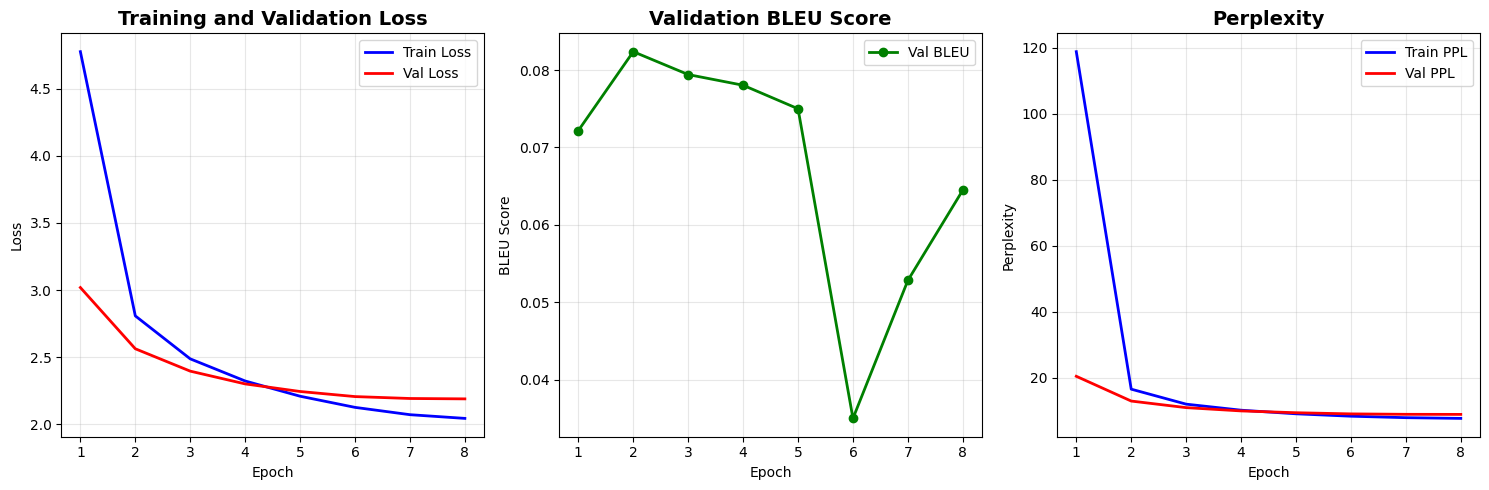

📊 Графики и метрики сохранены в /kaggle/working/outputs/

📈 Финальные результаты:
   🏆 Лучший BLEU: 0.082
   📉 Финальный Train Loss: 2.0433
   📊 Финальный Val Loss: 2.1888
   ⏰ Время обучения: 0.8 часов


In [13]:
# 📊 Визуализация результатов обучения

plt.figure(figsize=(15, 5))

# График loss
plt.subplot(1, 3, 1)
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
plt.plot(epochs_range, val_losses, 'r-', label='Val Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# График BLEU
plt.subplot(1, 3, 2)
plt.plot(epochs_range, val_bleus, 'g-', label='Val BLEU', linewidth=2, marker='o')
plt.title('Validation BLEU Score', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.legend()
plt.grid(True, alpha=0.3)

# График Perplexity
plt.subplot(1, 3, 3)
train_ppl = [math.exp(min(loss, 10)) for loss in train_losses]
val_ppl = [math.exp(min(loss, 10)) for loss in val_losses]
plt.plot(epochs_range, train_ppl, 'b-', label='Train PPL', linewidth=2)
plt.plot(epochs_range, val_ppl, 'r-', label='Val PPL', linewidth=2)
plt.title('Perplexity', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{KAGGLE_WORKING}/outputs/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Сохраняем метрики в файл
metrics_data = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_bleus': val_bleus,
    'best_bleu': best_bleu,
    'total_time_hours': total_time/3600,
    'config': TRAINING_CONFIG,
    'model_config': model.get_config()
}

with open(f'{KAGGLE_WORKING}/outputs/training_metrics.json', 'w') as f:
    json.dump(metrics_data, f, indent=2)

print(f"📊 Графики и метрики сохранены в {KAGGLE_WORKING}/outputs/")
print(f"\n📈 Финальные результаты:")
print(f"   🏆 Лучший BLEU: {best_bleu:.3f}")
print(f"   📉 Финальный Train Loss: {train_losses[-1]:.4f}")
print(f"   📊 Финальный Val Loss: {val_losses[-1]:.4f}")
print(f"   ⏰ Время обучения: {total_time/3600:.1f} часов")


In [14]:
# 🧪 Финальное тестирование модели

print("🧪 Финальное тестирование на test set...")

# Оценка на тестовом наборе
test_loss, test_bleu, test_examples = evaluate_model(
    model, test_loader, criterion, device, (en_tokenizer, ru_tokenizer), num_examples=10
)

print(f"\n🎯 Результаты на test set:")
print(f"   📊 Test Loss: {test_loss:.4f} (PPL: {math.exp(min(test_loss, 10)):.2f})")
print(f"   🏆 Test BLEU: {test_bleu:.3f}")

# Демонстрация переводов
print(f"\n📝 Примеры переводов на test set:")
print("=" * 80)

for i, example in enumerate(test_examples[:8]):
    print(f"\n{i+1}. 🇺🇸 EN: '{example['source']}'")
    print(f"   🇷🇺 RU: '{example['reference']}'")
    print(f"   🤖 AI: '{example['generated']}'")
    print(f"   📊 BLEU: {example['bleu']:.3f}")
    
    # Простая оценка качества
    if example['bleu'] > 0.3:
        quality = "🟢 Отлично"
    elif example['bleu'] > 0.15:
        quality = "🟡 Хорошо"
    else:
        quality = "🔴 Нужно улучшение"
    print(f"   ✨ Качество: {quality}")

print("\n" + "=" * 80)

# Интерактивные примеры
print(f"\n🎮 Интерактивное тестирование:")
test_sentences = [
    "Hello world",
    "How are you doing today?",
    "I love learning new languages",
    "The weather is beautiful today",
    "Can you help me please?",
    "Thank you very much",
    "I want to travel to Russia",
    "This is an amazing experience"
]

special_tokens = ru_tokenizer.get_special_token_ids()

for i, test_sent in enumerate(test_sentences):
    print(f"\n{i+1}. EN: '{test_sent}'")
    
    # Кодируем
    src_ids = torch.tensor([en_tokenizer.encode(test_sent, max_length=64)]).to(device)
    
    # Генерируем перевод
    with torch.no_grad():
        translation_ids = model.generate_translation(
            src_ids,
            max_length=50,
            bos_token=special_tokens['bos'],
            eos_token=special_tokens['eos'],
            pad_token=special_tokens['pad']
        )
    
    # Декодируем
    translation = ru_tokenizer.decode(translation_ids[0].tolist())
    print(f"    RU: '{translation}'")

# Сохранение результатов тестирования
test_results = {
    'test_loss': test_loss,
    'test_bleu': test_bleu,
    'test_examples': test_examples,
    'interactive_tests': [
        {'en': sent, 'ru': ru_tokenizer.decode(
            model.generate_translation(
                torch.tensor([en_tokenizer.encode(sent, max_length=64)]).to(device),
                max_length=50,
                bos_token=special_tokens['bos'],
                eos_token=special_tokens['eos'],
                pad_token=special_tokens['pad']
            )[0].tolist()
        )} for sent in test_sentences
    ]
}

with open(f'{KAGGLE_WORKING}/outputs/test_results.json', 'w', encoding='utf-8') as f:
    json.dump(test_results, f, indent=2, ensure_ascii=False)

print(f"\n💾 Результаты тестирования сохранены в {KAGGLE_WORKING}/outputs/test_results.json")

# Итоговая статистика
print(f"\n🎉 ИТОГОВЫЕ РЕЗУЛЬТАТЫ ОБУЧЕНИЯ:")
print(f"   📊 Параметров модели: {model.count_parameters():,}")
print(f"   📈 Лучший BLEU (val): {best_bleu:.3f}")
print(f"   🧪 Финальный BLEU (test): {test_bleu:.3f}")
print(f"   ⏰ Время обучения: {total_time/3600:.1f} часов")
print(f"   💾 Размер модели: {model.count_parameters() * 4 / 1e6:.1f} MB")
print(f"   🖥️ Устройство: {device}")

# Сохранение токенизаторов
en_tokenizer.save('en_tokenizer')
ru_tokenizer.save('ru_tokenizer')

print(f"\n✅ Обучение и тестирование завершено!")
print(f"📁 Все результаты сохранены в {KAGGLE_WORKING}/")
print(f"🎯 Модель готова для использования!")


🧪 Финальное тестирование на test set...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



🎯 Результаты на test set:
   📊 Test Loss: 2.1834 (PPL: 8.88)
   🏆 Test BLEU: 0.040

📝 Примеры переводов на test set:

1. 🇺🇸 EN: 'I didn't know you knew.'
   🇷🇺 RU: 'Я не знал, что вы знаете.'
   🤖 AI: 'не знал, что ты знаешь............... знала.. знала.'
   📊 BLEU: 0.163
   ✨ Качество: 🟡 Хорошо

2. 🇺🇸 EN: 'I'll have a talk with Tom.'
   🇷🇺 RU: 'У меня будет разговор с Томом.'
   🤖 AI: 'я буду говорить с Томом.....................'
   📊 BLEU: 0.044
   ✨ Качество: 🔴 Нужно улучшение

3. 🇺🇸 EN: 'I tried to tell you.'
   🇷🇺 RU: 'Я пытался вам сказать.'
   🤖 AI: 'сказать тебе.................. сказать...'
   📊 BLEU: 0.000
   ✨ Качество: 🔴 Нужно улучшение

4. 🇺🇸 EN: 'You did all you could.'
   🇷🇺 RU: 'Ты сделал всё, что мог.'
   🤖 AI: 'тебя могли бы сделать........ мог... моге. мог. мог бы вы моге. моге. было мог'
   📊 BLEU: 0.014
   ✨ Качество: 🔴 Нужно улучшение

5. 🇺🇸 EN: 'At last, we got to the lake.'
   🇷🇺 RU: 'Наконец мы добрались до озера.'
   🤖 AI: 'мы должны до смерти на озеро.м....